In [ ]:
# Import
import numpy as np # Import the numpy library for numerical operations

import torch # Import the PyTorch library
from torch import nn # Import the neural network module from PyTorch

from torchvision import datasets # Import the datasets module from torchvision, which contains standard datasets like MNIST
from torchvision.transforms import ToTensor, transforms # Import the ToTensor transform to convert PIL Images to PyTorch Tensors
from torch.utils.data import Subset # Import the Subset class from torch.utils.data
from torch.utils.data import DataLoader # Import the DataLoader class from torch.utils.data
from sklearn.metrics import accuracy_score # Import the accuracy_score function from scikit-learn

# Import matplotlib for visualization
import matplotlib.pyplot as plt # Import the matplotlib.pyplot module for creating plots and visualizations

1) Load data

In [ ]:
# Setup training data
transform = transforms.Compose([
    transforms.ToTensor() # Define a transform to convert images to PyTorch tensors
])

train_data = datasets.MNIST(
    root="data", # Specify the directory where the dataset will be downloaded
    train=True, # Indicate that this is the training dataset
    download=True, # Download the dataset if it's not already present
    transform=transform, # Apply the ToTensor transform to the loaded images
    target_transform=None # No transformation applied to the labels
)

# Setup testing data
test_data = datasets.MNIST(
    root="data", # Specify the directory where the dataset is located
    train=False, # Indicate that this is the test dataset
    download=True, # Download the dataset if it's not already present
    transform=transform # Apply the ToTensor transform to the loaded images
)

# See classes
class_names = train_data.classes # Get the list of class names (digits 0-9) from the training data
class_names # Display the list of class names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

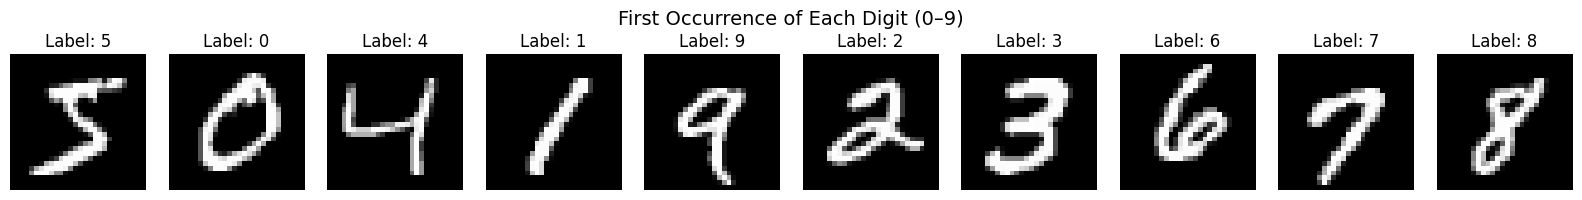

In [ ]:
# Visualize the first 10 unique digits from 0 to 9
fig, axs = plt.subplots(1, 10, figsize=(16, 2))
fig.suptitle("First Occurrence of Each Digit (0–9)", fontsize=14)

seen_digits = set()
shown = 0

# Loop through the dataset and plot the first instance of each class
for idx, (img, lbl) in enumerate(train_data):
    if lbl not in seen_digits:
        axs[shown].imshow(img.squeeze(), cmap="gray")
        axs[shown].set_title(f"Label: {lbl}")
        axs[shown].axis("off")
        seen_digits.add(lbl)
        shown += 1
    if shown == 10:
        break

plt.tight_layout()
plt.show()

2) Data preparation

In [ ]:
# Setup the batch size hyperparameter
BATCH_SIZE = 1024 # Define the number of samples per batch
num_batches = 2
subset_size = BATCH_SIZE * num_batches # Keep 4 batches only

all_indices = torch.randperm(len(train_data))  # mixed indices
subset_indices = all_indices[:subset_size]     # keep only subset_size

# Create Subset
train_subset = Subset(train_data, subset_indices)
test_subset = Subset(train_data, subset_indices)

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_subset, # Use the training dataset
    batch_size=BATCH_SIZE, # Set the batch size for the training data
    shuffle=True # Shuffle the data at the beginning of each epoch for better training
)

test_dataloader = DataLoader(test_subset, # Use the test dataset
    batch_size=BATCH_SIZE, # Set the batch size for the test data
    shuffle=False # No need to shuffle test data for evaluation
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") # Print the DataLoader objects
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}") # Print the number of batches in the training DataLoader
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}") # Print the number of batches in the test DataLoader

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x79102a430510>, <torch.utils.data.dataloader.DataLoader object at 0x79102c06a150>)
Length of train dataloader: 2 batches of 1024
Length of test dataloader: 2 batches of 1024


3) Model difinition with and without layers for prevent overfitting

In [ ]:
# Define a simple Convolutional Neural Network (CNN) by subclassing nn.Module
class SimpleCNN(nn.Module):

    def __init__(self, input_size=1, hidden_unit=32, dim_image=28, num_classes=10):
        '''
        Initializes the model with default or user-defined parameters:
         - input_size: number of input channels (e.g., 1 for grayscale, 3 for RGB)
         - hidden_unit: base number of filters for the convolutional layers
         - dim_image: height/width of the input image (assumes square input, e.g., 28x28)
         - num_classes: number of output classes for classification
        '''
        super(SimpleCNN, self).__init__()
        '''
        This line calls the constructor of the parent class (nn.Module).
        It's crucial for proper initialization of the PyTorch module system.
        '''

        # --- Convolutional Block 1 ---
        # First convolutional layer: accepts `input_size` channels (e.g., 1 for grayscale)
        # and outputs `hidden_unit` channels with 3x3 kernels and padding to preserve spatial size
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=hidden_unit, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()  # Apply ReLU activation function

        # --- Convolutional Block 2 ---
        # Second convolutional layer: doubles the number of channels
        self.conv2 = nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit*2, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()  # Apply ReLU activation function

        # --- MaxPooling Layer ---
        # Downsamples the spatial dimensions by a factor of 2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # --- Classifier (Fully Connected Layers) ---
        # Compute flattened size after pooling: each dimension is halved
        linear_input_size = int((hidden_unit*2) * (dim_image/2) * (dim_image/2))
        # First fully connected layer: projects to a higher-dimensional space
        self.fc1 = nn.Linear(linear_input_size, hidden_unit*4)
        self.relu3 = nn.ReLU()  # Apply ReLU activation function
        # Final fully connected layer: maps to number of output classes
        self.fc2 = nn.Linear(hidden_unit*4, num_classes)

        # Softmax layer not needed here because CrossEntropyLoss includes it
        # self.softmax = nn.Softmax(1)

    # Define the forward pass through the network
    def forward(self, x):
        # --- Convolutional Block 1 ---
        x = self.conv1(x)  # Apply first convolution
        x = self.relu1(x)  # Apply activation

        # --- Convolutional Block 2 ---
        x = self.conv2(x)  # Apply second convolution
        x = self.relu2(x)  # Apply activation

        # --- Pooling ---
        x = self.pool(x)  # Apply max pooling to reduce spatial size

        # --- Flattening ---
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch size

        # --- Fully Connected Layers ---
        x = self.fc1(x)    # First dense layer
        x = self.relu3(x)  # Activation
        x = self.fc2(x)    # Final output layer

        # Softmax not applied explicitly since CrossEntropyLoss expects raw logits
        # x = self.softmax(x)

        return x  # Return output logits

In [ ]:
# Define an advanced CNN with batch normalization and dropout for better generalization
class AdvancedCNN(nn.Module):
    def __init__(self, input_size=1, hidden_unit=32, dim_image=28, num_classes=10):
        '''
          Initializes the model with default or user-defined parameters:
          - input_size: number of input channels (e.g., 1 for grayscale, 3 for RGB)
          - hidden_unit: base number of filters for the convolutional layers
          - dim_image: height/width of the input image (assumes square input, e.g., 28x28)
          - num_classes: number of output classes for classification
        '''
        super(AdvancedCNN, self).__init__()
        '''
        This line calls the constructor of the parent class (nn.Module).
        It's crucial for proper initialization of the PyTorch module system.
        '''

        # --- Convolutional Block 1 ---
        # First convolutional layer: transforms input channels to `hidden_unit` feature maps
        self.conv1 = nn.Conv2d(in_channels=input_size, out_channels=hidden_unit, kernel_size=3, padding=1)
        # Batch normalization to stabilize and accelerate training
        self.bn1 = nn.BatchNorm2d(hidden_unit)
        # ReLU activation to introduce non-linearity
        self.relu1 = nn.ReLU()
        # Dropout to prevent overfitting (25% of features randomly zeroed)
        self.dropout1 = nn.Dropout(0.25)

        # --- Convolutional Block 2 ---
        # Second convolutional layer: increases channels to hidden_unit * 2
        self.conv2 = nn.Conv2d(in_channels=hidden_unit, out_channels=hidden_unit*2, kernel_size=3, padding=1)
        # Batch normalization for the new number of channels
        self.bn2 = nn.BatchNorm2d(hidden_unit*2)
        # ReLU activation
        self.relu2 = nn.ReLU()
        # Dropout again to regularize
        self.dropout2 = nn.Dropout(0.25)

        # --- MaxPooling Layer ---
        # Downsample the feature maps by a factor of 2 (halves width and height)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # --- Fully Connected Block ---
        # Calculate the input size for the first dense layer after flattening
        linear_input_size = int((hidden_unit*2) * (dim_image/2) * (dim_image/2))
        # First dense (fully connected) layer to project features to a higher dimension
        self.fc1 = nn.Linear(linear_input_size, hidden_unit*4)
        # Batch normalization on fully connected output
        self.bn3 = nn.BatchNorm1d(hidden_unit*4)
        # ReLU activation
        self.relu3 = nn.ReLU()
        # Dropout to regularize the dense layer (50% dropout rate)
        self.dropout3 = nn.Dropout(0.5)
        # Final dense layer to map to the number of classes
        self.fc2 = nn.Linear(hidden_unit*4, num_classes)
        # Softmax to convert raw logits to class probabilities (note: usually done outside model with CrossEntropyLoss)
        self.softmax = nn.Softmax(1)

    # Define the forward pass through the model
    def forward(self, x):
        # --- Convolutional Block 1 ---
        x = self.conv1(x)      # Apply first convolution
        x = self.bn1(x)        # Apply batch normalization
        x = self.relu1(x)      # Apply ReLU activation
        x = self.dropout1(x)   # Apply dropout

        # --- Convolutional Block 2 ---
        x = self.conv2(x)      # Apply second convolution
        x = self.bn2(x)        # Apply batch normalization
        x = self.relu2(x)      # Apply ReLU activation
        x = self.dropout2(x)   # Apply dropout

        # --- Pooling ---
        x = self.pool(x)       # Downsample feature maps

        # --- Flattening ---
        x = torch.flatten(x, 1)  # Flatten all dimensions except the batch size

        # --- Fully Connected Block ---
        x = self.fc1(x)        # First dense layer
        x = self.bn3(x)        # Batch normalization
        x = self.relu3(x)      # ReLU activation
        x = self.dropout3(x)   # Dropout
        x = self.fc2(x)        # Final dense layer
        x = self.softmax(x)    # Convert to class probabilities

        return x  # Return the final output

Check for GPU availability and select GPU if available

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Instantiate models and move them to the device (CPU or GPU)

In [ ]:
# Instantiate models :
# Wihout Batch Normalization and dropout
model_simple = SimpleCNN(input_size=1, hidden_unit=32, dim_image=28, num_classes=10) # Create an instance of the SimpleCNN model defined earlier
model_simple = SimpleCNN().to(device) # Move all variables of SimpleCNN to device

# With Batch Normalization and dropout
model_advanced = AdvancedCNN(input_size=1, hidden_unit=32, dim_image=28, num_classes=10) # Create an instance of the AdvancedCNN model defined earlier
model_advanced = AdvancedCNN().to(device) # Move all variables of SimpleCNN to device


4) Train and evaluate the model. We want to train our two models separately, so to write the training procedure only once, we can integrate it into a function that we'll call later.


In [ ]:
def train_and_test_procedure(model, train_dataloader, test_dataloader, epochs, optimizer, loss_fn, device):
    # Storage for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Training and testing loop
    for epoch in range(epochs): # Loop through each epoch
        for X_train, y_train in train_dataloader : # Iterate through batches of training data
            running_loss = 0.0
            train_preds = []
            train_labels = []

            X_train = X_train.to(device)
            y_train = y_train.to(device)
            model.train() # Set the model to training mode (enables dropout, batch normalization, etc.)
            outputs = model(X_train) # Perform a forward pass to get model outputs (predictions)
            loss = loss_fn(outputs, y_train) # Calculate the loss between the model outputs and the true labels

            optimizer.zero_grad() # Zero the gradients of the optimizer
            loss.backward() # Perform backpropagation to calculate gradients
            optimizer.step() # Update the model's parameters based on the calculated gradients

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            train_preds.append(preds.cpu())
            train_labels.append(y_train.cpu())

        # Compute average training loss and accuracy
        train_loss_epoch = running_loss / len(train_dataloader)
        train_losses.append(train_loss_epoch)

        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)
        train_acc = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_acc)

        # Evaluation loop
        model.eval()
        test_preds = []
        test_labels = []
        test_loss_total = 0.0

        with torch.inference_mode():
            for X_test, y_test in test_dataloader:
                X_test = X_test.to(device)
                y_test = y_test.to(device)

                test_outputs = model(X_test)
                test_loss = loss_fn(test_outputs, y_test)
                test_loss_total += test_loss.item()

                preds = torch.argmax(test_outputs, dim=1)
                test_preds.append(preds.cpu())
                test_labels.append(y_test.cpu())

        test_loss_epoch = test_loss_total / len(test_dataloader)
        test_losses.append(test_loss_epoch)

        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)
        test_acc = accuracy_score(test_labels, test_preds)
        test_accuracies.append(test_acc)

        # Print metrics
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss_epoch:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss_epoch:.4f} | Test Acc: {test_acc:.4f}")
    return train_losses, test_losses, train_accuracies, test_accuracies



Definition of loss function and optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss() # Define the loss function as Cross-Entropy Loss, commonly used for classification
optimizer_model_simple = torch.optim.Adam(model_simple.parameters(), lr=0.01) # Define the optimizer as Adam, with a learning rate of 0.01. It will update the model's parameters.
optimizer_model_advanced = torch.optim.Adam(model_advanced.parameters(), lr=0.01) # Define the optimizer as Adam, with a learning rate of 0.01. It will update the model's parameters.
epochs = 10 # Define the number of training epochs

Train simple model (without Batch Normalization and Dropout)

In [ ]:
train_losses_simple, test_losses_simple, train_accuracies_simple, test_accuracies_simple = train_and_test_procedure(model_simple,
                                                                                                                    train_dataloader,
                                                                                                                    test_dataloader,
                                                                                                                    epochs,
                                                                                                                    optimizer_model_simple,
                                                                                                                    loss_fn,
                                                                                                                    device)

Epoch 1/10 | Train Loss: 3.8749 | Train Acc: 0.2012 | Test Loss: 2.8791 | Test Acc: 0.1401
Epoch 2/10 | Train Loss: 1.1051 | Train Acc: 0.3096 | Test Loss: 2.0933 | Test Acc: 0.3184
Epoch 3/10 | Train Loss: 0.9376 | Train Acc: 0.4023 | Test Loss: 1.5705 | Test Acc: 0.6748
Epoch 4/10 | Train Loss: 0.6234 | Train Acc: 0.7734 | Test Loss: 0.9057 | Test Acc: 0.7686
Epoch 5/10 | Train Loss: 0.3689 | Train Acc: 0.7861 | Test Loss: 0.6646 | Test Acc: 0.7939
Epoch 6/10 | Train Loss: 0.3135 | Train Acc: 0.8057 | Test Loss: 0.5722 | Test Acc: 0.8438
Epoch 7/10 | Train Loss: 0.3198 | Train Acc: 0.8125 | Test Loss: 0.4941 | Test Acc: 0.8638
Epoch 8/10 | Train Loss: 0.2779 | Train Acc: 0.8408 | Test Loss: 0.4388 | Test Acc: 0.8818
Epoch 9/10 | Train Loss: 0.2095 | Train Acc: 0.8838 | Test Loss: 0.4343 | Test Acc: 0.8672
Epoch 10/10 | Train Loss: 0.1850 | Train Acc: 0.9062 | Test Loss: 0.3382 | Test Acc: 0.8984


Train advanced model (with Batch Normalization and Dropout)

In [ ]:
train_losses_advanced, test_losses_advanced, train_accuracies_advanced, test_accuracies_advanced = train_and_test_procedure(model_advanced,
                                                                                                                            train_dataloader,
                                                                                                                            test_dataloader,
                                                                                                                            epochs,
                                                                                                                            optimizer_model_advanced,
                                                                                                                            loss_fn,
                                                                                                                            device)

Epoch 1/10 | Train Loss: 1.0340 | Train Acc: 0.6201 | Test Loss: 2.0982 | Test Acc: 0.5547
Epoch 2/10 | Train Loss: 0.9273 | Train Acc: 0.7754 | Test Loss: 2.0851 | Test Acc: 0.7290
Epoch 3/10 | Train Loss: 0.8684 | Train Acc: 0.8525 | Test Loss: 2.0906 | Test Acc: 0.4688
Epoch 4/10 | Train Loss: 0.8247 | Train Acc: 0.8955 | Test Loss: 2.1257 | Test Acc: 0.2979
Epoch 5/10 | Train Loss: 0.7935 | Train Acc: 0.9336 | Test Loss: 2.1785 | Test Acc: 0.2056
Epoch 6/10 | Train Loss: 0.7786 | Train Acc: 0.9404 | Test Loss: 2.2427 | Test Acc: 0.1460
Epoch 7/10 | Train Loss: 0.7674 | Train Acc: 0.9492 | Test Loss: 2.2586 | Test Acc: 0.1445
Epoch 8/10 | Train Loss: 0.7605 | Train Acc: 0.9648 | Test Loss: 2.2647 | Test Acc: 0.1460
Epoch 9/10 | Train Loss: 0.7555 | Train Acc: 0.9648 | Test Loss: 2.2752 | Test Acc: 0.1333
Epoch 10/10 | Train Loss: 0.7538 | Train Acc: 0.9688 | Test Loss: 2.2928 | Test Acc: 0.1221


5) Visualisation of results
For the same purpose we create a function for displaying more easily the evolution of the loss and the accuracy for the different models.



In [ ]:
def plot_loss_and_accuracy(train_losses, test_losses, train_accuracies, test_accuracies, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # --- Loss Plot ---
    # Left Y-axis: Train Loss
    ax1.plot(train_losses, label='Train Loss', color='tab:orange')
    ax1.set_ylabel('Train Loss', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:orange')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Loss over Epochs')

    # Right Y-axis: Test Loss
    ax1b = ax1.twinx()
    ax1b.plot(test_losses, label='Test Loss', color='tab:blue')
    ax1b.set_ylabel('Test Loss', color='tab:blue')
    ax1b.tick_params(axis='y', labelcolor='tab:blue')

    # Optional: combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1b.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper right')

    # --- Accuracy Plot ---
    ax2.plot(train_accuracies, label='Train Accuracy', color='tab:orange')
    ax2.plot(test_accuracies, label='Test Accuracy', color='tab:blue')
    ax2.set_title('Accuracy over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


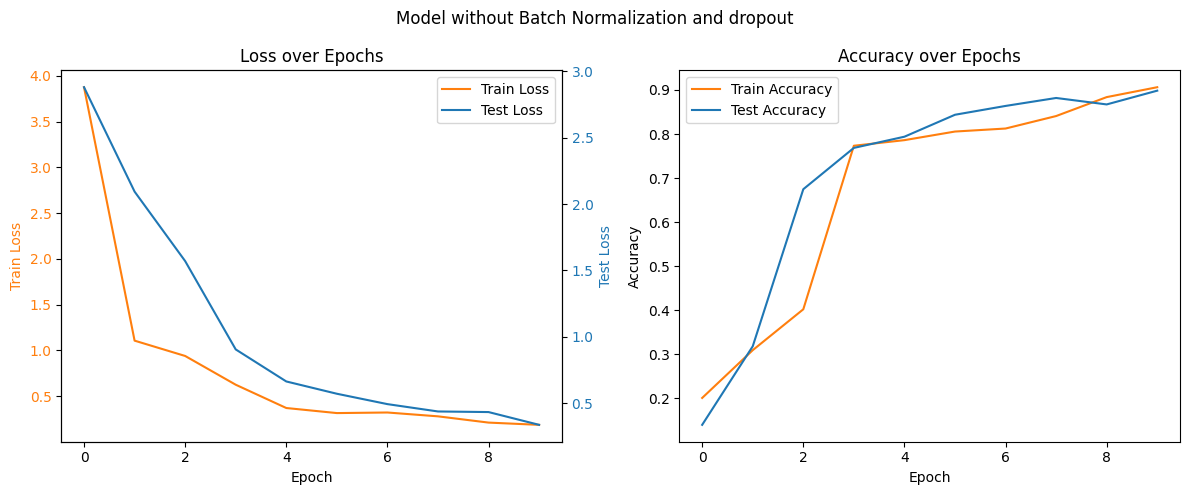

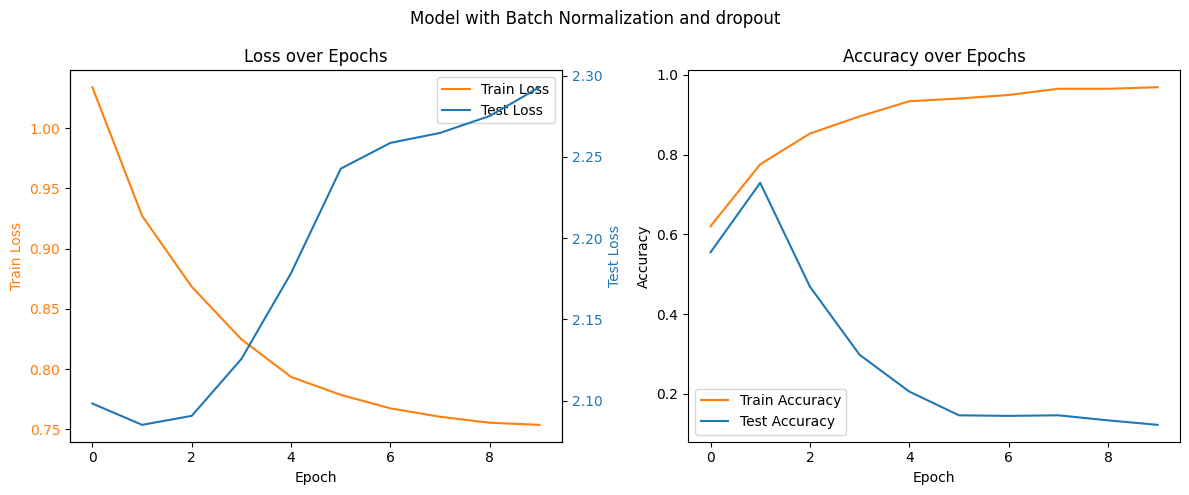

In [ ]:
title = "Model without Batch Normalization and dropout"
plot_loss_and_accuracy(train_losses_simple, test_losses_simple, train_accuracies_simple, test_accuracies_simple, title)

title = "Model with Batch Normalization and dropout"
plot_loss_and_accuracy(train_losses_advanced, test_losses_advanced, train_accuracies_advanced, test_accuracies_advanced, title)

### Exercice 1:
Analyze the results, what happened during the training and why ?

### Exercice 2:
Create new models by testing :

* suppress batch normalization on dense layers
* use only batch normalization on convolutional layers
* use only dropouts and supress the batch normalization

If you have access to GPU, you can also try to increase the size of your dataset

Train some of theses new models and compare the evolution of loss and accuracy

In [ ]:
# Define your new Convolutional Neural Network (CNN)
class NewCNN(nn.Module):
    # Initialize your layers
    def __init__(self, input_size=1, hidden_unit=32, dim_image=28, num_classes=10):
        super(NewCNN, self).__init__()


    # Define the forward pass through the network
    def forward(self, x):


        return x  # Return output logits

In [ ]:
# Instanciate model
# your code here

# Define your loss function, optimizer and number of epoch (maintain at 10)
# your code here

# train and evaluate your model
# your code here

# visualize your results
# your code here

## Bonus : data augmentation
Try to apply data augmentation to your fruits dataset

In [ ]:
## PLEASE DON'T MODIFY THIS CELL
import os
import gdown
import zipfile
from torch.utils.data import DataLoader, random_split, ConcatDataset

# Paths and file ID
dataset_folder = "/content/fruits_dataset"
zip_path = "/content/fruits_dataset.zip"
file_id = "153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a"

# Download only if zip not already present
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    gdown.download(id=file_id, output=zip_path, fuzzy=True)
else:
    print("Zip file already exists. Skipping download.")

# Extract only if fruits_dataset/ does not already exist
if not os.path.exists(dataset_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
else:
    print("Dataset already extracted.")

# Move apples and pears into fruits_dataset/ if they exist directly under /content
for folder in ["apples", "pears", "Pears"]:
    src = f"/content/{folder}"
    dst = f"/content/fruits_dataset/{folder.lower()}"
    if os.path.exists(src) and not os.path.exists(dst):
        os.makedirs("/content/fruits_dataset", exist_ok=True)
        os.rename(src, dst)

# Confirm class folders
print("Available classes:", os.listdir("/content/fruits_dataset"))


Zip file already exists. Skipping download.
Dataset already extracted.
Available classes: ['apples', 'pears']


In [ ]:
# Define original transform (to apply to all images)
# --- Base transform (mild preprocessing) ---
original_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=28, scale=(0.9, 1.1)),
    transforms.ToTensor()
])

# --- Define separate augmentation transforms ---
transform_rotation = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.ToTensor()
])

transform_translation = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor()
])

transform_hflip = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ToTensor()
])

transform_vflip = transforms.Compose([
    transforms.RandomVerticalFlip(p=1.0),
    transforms.ToTensor()
])

transform_blur = transforms.Compose([
    transforms.GaussianBlur(kernel_size=125, sigma=3),
    transforms.ToTensor()
])

transform_color_jitter = transforms.Compose([
    transforms.ColorJitter(brightness=0.9, contrast=0.4, saturation=0.2, hue=0.1),
    transforms.ToTensor()
])



In [ ]:
# Load dataset
data_dir = "/content/fruits_dataset"

# Load original dataset
original_dataset     = datasets.ImageFolder(root=data_dir, transform=original_transform)

# Create augmented version of the same dataset
rotated_dataset      = datasets.ImageFolder(root=data_dir, transform=transform_rotation)
translated_dataset   = datasets.ImageFolder(root=data_dir, transform=transform_translation)
hflipped_dataset     = datasets.ImageFolder(root=data_dir, transform=transform_hflip)
vflipped_dataset     = datasets.ImageFolder(root=data_dir, transform=transform_vflip)
blur_dataset         = datasets.ImageFolder(root=data_dir, transform=transform_blur)
color_jitter_dataset = datasets.ImageFolder(root=data_dir, transform=transform_color_jitter)


# Combine all datasets to expand the training data
combined_dataset = ConcatDataset([
    original_dataset,
    rotated_dataset,
    translated_dataset,
    hflipped_dataset,
    vflipped_dataset,
    blur_dataset,
    color_jitter_dataset

])

# Split into train/validation
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size
train_ds, val_ds = random_split(combined_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)

# Class info and sizes
class_names = original_dataset.classes
print("Classes:", class_names)
print("Original dataset size:     ", len(original_dataset))
print("Rotation dataset size:     ", len(rotated_dataset))
print("Translation dataset size:  ", len(translated_dataset))
print("H-Flip dataset size:       ", len(hflipped_dataset))
print("V-Flip dataset size:       ", len(vflipped_dataset))
print("Blur dataset size:         ", len(blur_dataset))
print("Color Jiter dataset size:  ", len(color_jitter_dataset))
print("Final combined dataset size:", len(combined_dataset))
print("Train set size:            ", len(train_ds))
print("Validation set size:       ", len(val_ds))

Classes: ['apples', 'pears']
Original dataset size:      313
Rotation dataset size:      313
Translation dataset size:   313
H-Flip dataset size:        313
V-Flip dataset size:        313
Blur dataset size:          313
Color Jiter dataset size:   313
Final combined dataset size: 2191
Train set size:             1752
Validation set size:        439


Visualization of one original image and augmented versions

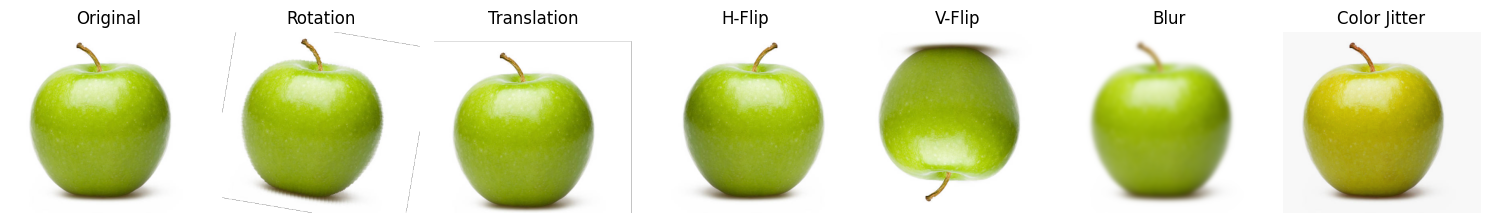

In [ ]:
from PIL import Image
# load one image
img_path, label = original_dataset.samples[0]
img = Image.open(img_path)

# Apply transforms (convert back to PIL for display)
to_pil = transforms.ToPILImage()

images = {
    "Original": img,
    "Rotation": to_pil(transform_rotation(img)),
    "Translation": to_pil(transform_translation(img)),
    "H-Flip": to_pil(transform_hflip(img)),
    "V-Flip": to_pil(transform_vflip(img)),
    "Blur": to_pil(transform_blur(img)),
    "Color Jitter": to_pil(transform_color_jitter(img))
}

# Plot all images in a row
plt.figure(figsize=(15, 3))
for i, (title, image) in enumerate(images.items()):
    plt.subplot(1, len(images), i + 1)
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()